In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import os


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/fer2013.csv')
#check data shape
data.shape

(35887, 3)

In [ ]:
data.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
data.Usage.value_counts()

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

In [ ]:
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Fear,5121
2,Sad,6077
3,Neutral,6198
4,Happy,8989
5,Surprise,4002
6,Digust,547


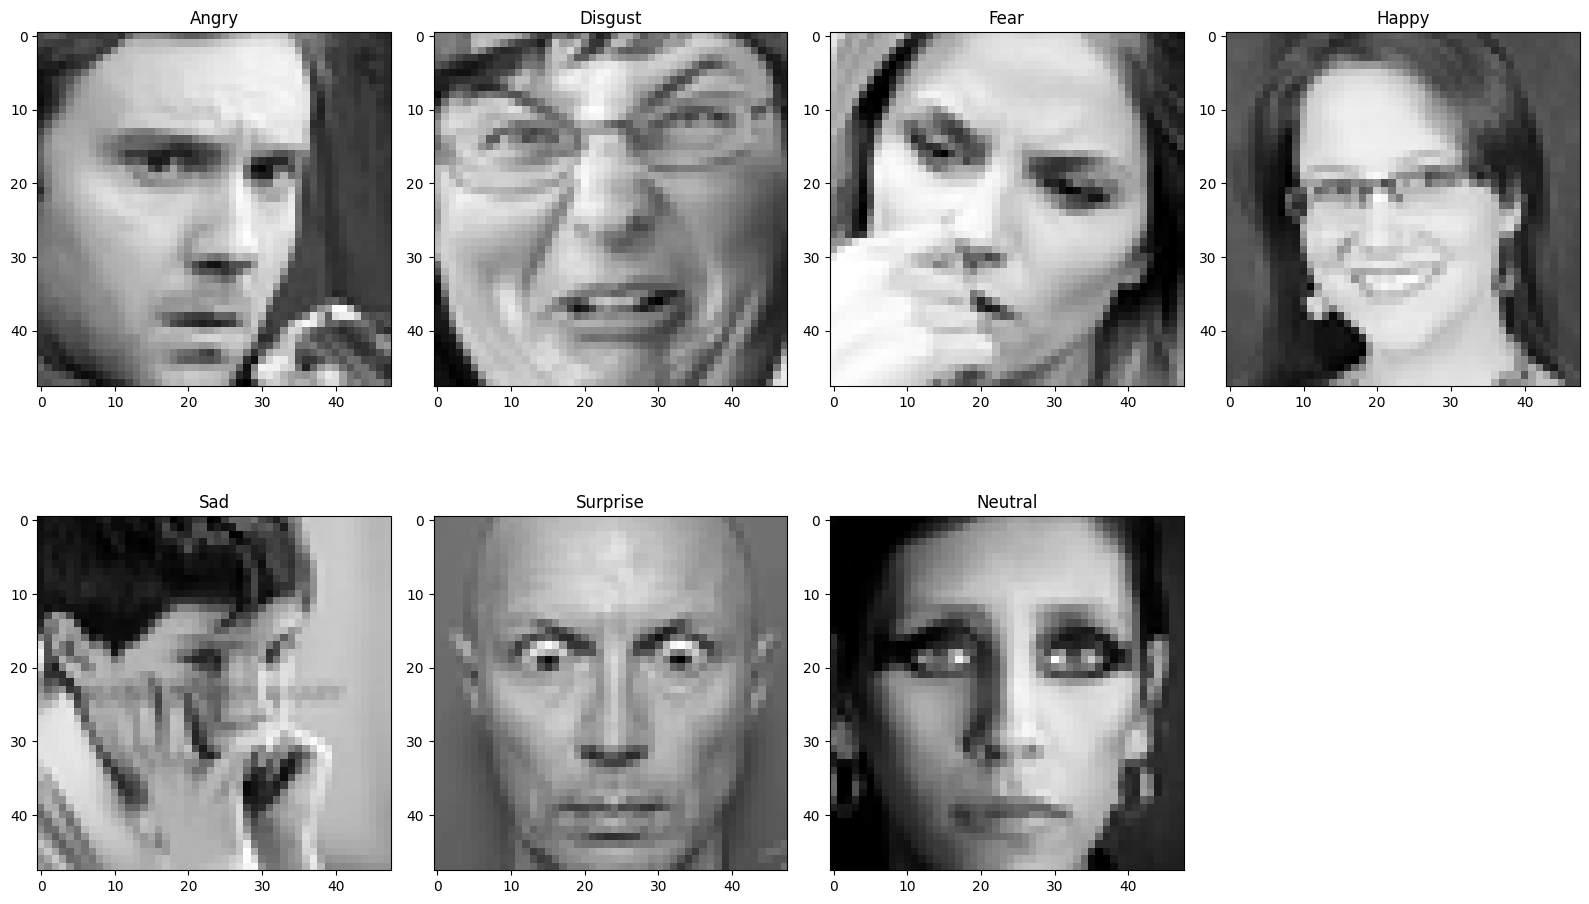

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define emotion map if not already defined
emotion_map = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

def row2image(row):
    pixels = row['pixels']
    emotion = emotion_map[row['emotion']]

    # Convert pixel string to numpy array of integers
    img = np.array(pixels.split()).astype(np.float32)

    # Reshape to 48x48 grayscale image
    img = img.reshape(48, 48)

    # Normalize pixel values to range [0, 255]
    img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255

    # Create 3-channel image (grayscale to RGB)
    image = np.stack((img,) * 3, axis=-1).astype(np.uint8)

    return image, emotion

plt.figure(figsize=(16, 10))
for i in range(1, 8):
    # Get the first sample of each emotion type
    face = data[data['emotion'] == i - 1].iloc[0]

    # Generate image and emotion label
    img, emotion_label = row2image(face)

    # Plot image
    plt.subplot(2, 4, i)
    plt.imshow(img)
    plt.title(emotion_label)

plt.tight_layout()
plt.show()


In [ ]:
data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


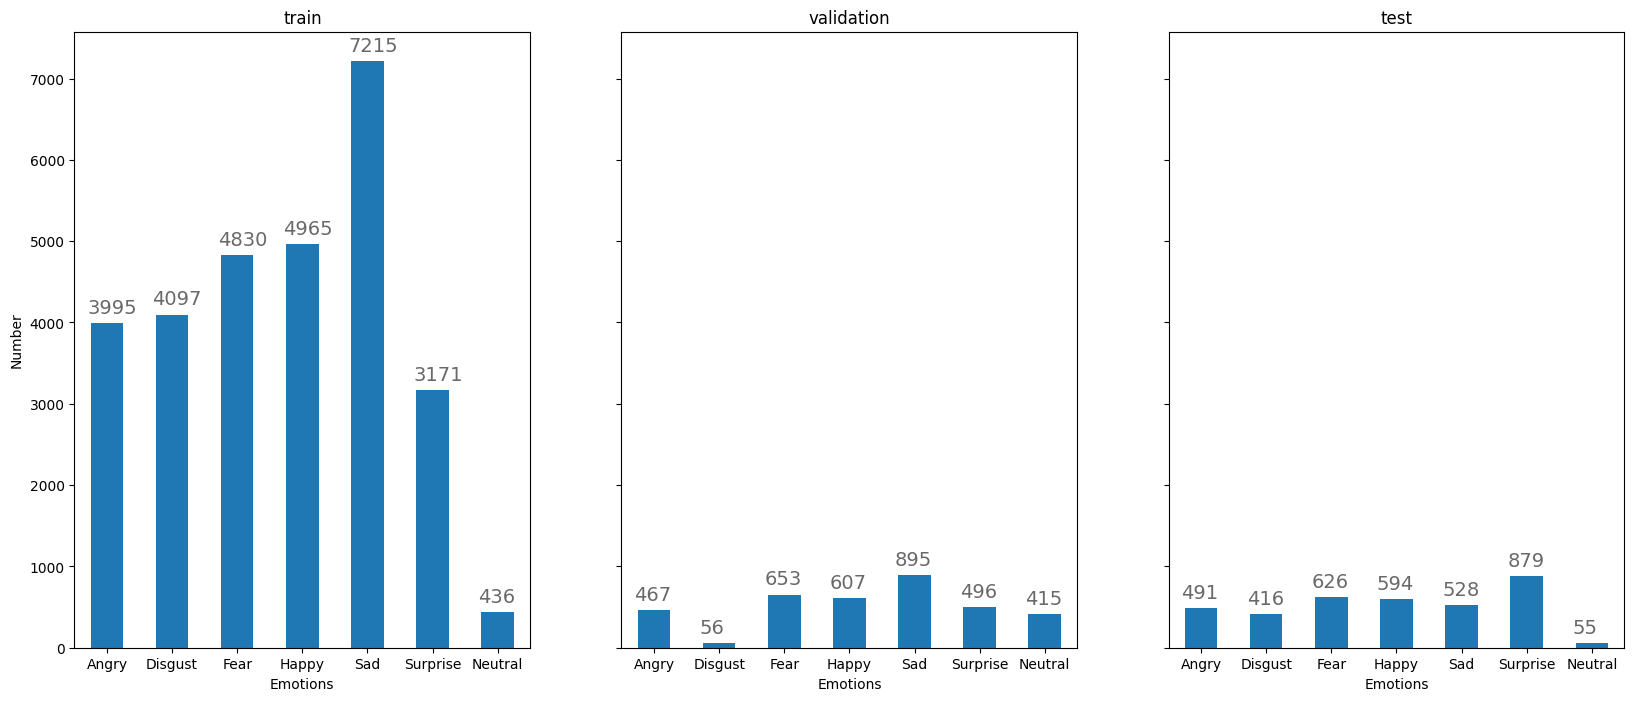

In [ ]:
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def setup_axe(axe,df,title):
    df['emotion'].value_counts(sort=False).plot(ax=axe, kind='bar', rot=0)
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)

    # set individual bar lables using above list
    for i in axe.patches:
        # get_x pulls left or right; get_height pushes up or down
        axe.text(i.get_x()-.05, i.get_height()+120, \
                str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                    rotation=0)


fig, axes = plt.subplots(1,3, figsize=(20,8), sharey=True)
setup_axe(axes[0],data_train,'train')
setup_axe(axes[1],data_val,'validation')
setup_axe(axes[2],data_test,'test')
plt.show()

In [ ]:
num_classes = 7
width, height = 48, 48
num_epochs = 50
batch_size = 64
num_features = 64

In [ ]:
  model = Sequential()

  #module 1
  model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

  #module 2
  model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

  #module 3
  model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

  #flatten
  model.add(Flatten())

  #dense 1
  model.add(Dense(2*2*2*num_features))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  #dense 2
  model.add(Dense(2*2*num_features))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  #dense 3
  model.add(Dense(2*num_features))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  #output layer
  model.add(Dense(num_classes, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
                metrics=['accuracy'])

  model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 256)       2560      
                                                                 
 batch_normalization (Batch  (None, 46, 46, 256)       1024      
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 46, 46, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 256)       590080    
                                                                 
 batch_normalization_1 (Bat  (None, 46, 46, 256)       1024      
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 46, 46, 256)       0